## MovieLens Rating Analysis

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## DATA PREPARATION

***Step1: Load the datasets***

In [104]:
ratings = pd.read_csv("C:/Users/Administrator/Documents/Data Analysis/HNG/ml-latest-small/ratings.csv")
movies = pd.read_csv("C:/Users/Administrator/Documents/Data Analysis/HNG/ml-latest-small/movies.csv")
tags = pd.read_csv("C:/Users/Administrator/Documents/Data Analysis/HNG/ml-latest-small/tags.csv")
links = pd.read_csv("C:/Users/Administrator/Documents/Data Analysis/HNG/ml-latest-small/links.csv")

***Step2: Merge Datasets*** 

In [105]:
df = pd.merge(ratings, movies, on="movieId" )
print(df.head())

   userId  movieId  rating  timestamp                        title  \
0       1        1     4.0  964982703             Toy Story (1995)   
1       1        3     4.0  964981247      Grumpier Old Men (1995)   
2       1        6     4.0  964982224                  Heat (1995)   
3       1       47     5.0  964983815  Seven (a.k.a. Se7en) (1995)   
4       1       50     5.0  964982931   Usual Suspects, The (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                               Comedy|Romance  
2                        Action|Crime|Thriller  
3                             Mystery|Thriller  
4                       Crime|Mystery|Thriller  


***Step3: Check for duplicates and missing values***

In [106]:
print("Duplicates:", df.duplicated().sum())
print("Missing values:", df.isnull().sum())

Duplicates: 0
Missing values: userId       0
movieId      0
rating       0
timestamp    0
title        0
genres       0
dtype: int64


***Step4: Convert timestamp into datetime format***

In [107]:
df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s")
print(df.head())

   userId  movieId  rating           timestamp                        title  \
0       1        1     4.0 2000-07-30 18:45:03             Toy Story (1995)   
1       1        3     4.0 2000-07-30 18:20:47      Grumpier Old Men (1995)   
2       1        6     4.0 2000-07-30 18:37:04                  Heat (1995)   
3       1       47     5.0 2000-07-30 19:03:35  Seven (a.k.a. Se7en) (1995)   
4       1       50     5.0 2000-07-30 18:48:51   Usual Suspects, The (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                               Comedy|Romance  
2                        Action|Crime|Thriller  
3                             Mystery|Thriller  
4                       Crime|Mystery|Thriller  


## FEATURE ENGINEERING
#### Creating New Features

**Feature 1: Release year**

In [108]:
df['release_year'] = df['title'].str.extract(r'\((\d{4})\)').astype(float)
df[['title', 'release_year']].head()

,title,release_year
0,Toy Story (1995),1995.0
1,Grumpier Old Men (1995),1995.0
2,Heat (1995),1995.0
3,Seven (a.k.a. Se7en) (1995),1995.0
4,"Usual Suspects, The (1995)",1995.0


**Feature 2: Decade**
*(Group movies into decades)*

In [109]:
df['decade'] = (df['release_year'] - (df['release_year'] % 10)).astype('Int64').astype(str) + 's'

df[['release_year', 'decade']].head()

,release_year,decade
0,1995.0,1990s
1,1995.0,1990s
2,1995.0,1990s
3,1995.0,1990s
4,1995.0,1990s


**Feature 3: Average Rating Per User**
*(Find the average rating each user gives)*

In [110]:
user_avg = df.groupby('userId')['rating'].mean().reset_index()
user_avg.rename(columns={'rating': 'avg_user_rating'}, inplace=True)
df = pd.merge(df, user_avg, on='userId', how='left')
df[['userId', 'rating', 'avg_user_rating']].head()


,userId,rating,avg_user_rating
0,1,4.0,4.366379
1,1,4.0,4.366379
2,1,4.0,4.366379
3,1,5.0,4.366379
4,1,5.0,4.366379


**Feature 4: Rating Year**
*(Find the total ratings in each year)*

In [111]:
# Extract the year when rating was made
df['rating_year'] = df['timestamp'].dt.year
df[['timestamp', 'rating_year']].head()

ratings_per_year = df.groupby('rating_year')['rating'].count().reset_index(name='num_ratings')
ratings_per_year = ratings_per_year.sort_values('rating_year')

print(ratings_per_year.head())

   rating_year  num_ratings
0         1996         6040
1         1997         1916
2         1998          507
3         1999         2439
4         2000        10061


**Feature 5: Number of Rating Per Movie**
*(Find how many ratings each movie has)*

In [112]:
num_ratings = df.groupby('movieId')['rating'].count().reset_index(name='num_ratings')
df = pd.merge(df, num_ratings, on='movieId', how='left')
print(num_ratings.head())

   movieId  num_ratings
0        1          215
1        2          110
2        3           52
3        4            7
4        5           49


**Feature 6: Number of Genre Per Movie** 
*(Find how many genre each movie has)*

In [113]:
df['num_genres'] = df['genres'].apply(lambda x: len(x.split('|')) if isinstance(x, str) else 0)
print(df[['genres', 'num_genres']].head())

                                        genres  num_genres
0  Adventure|Animation|Children|Comedy|Fantasy           5
1                               Comedy|Romance           2
2                        Action|Crime|Thriller           3
3                             Mystery|Thriller           2
4                       Crime|Mystery|Thriller           3


## EXPLORATORY DATA ANALYSIS (EDA)
The EDA focuses on answering the following critical questions:
- What does the overall distribution of ratings look like?
- How has rating activity changed over time?
- Which movies receive the highest ratings?
- Do users differ in how generously they rate movies?
- Are movies with multiple genres rated differently than single-genre films?
- Which decades produced the most-rated or highest-rated movies?

#### 1. What does the overall distribution of ratings look like?

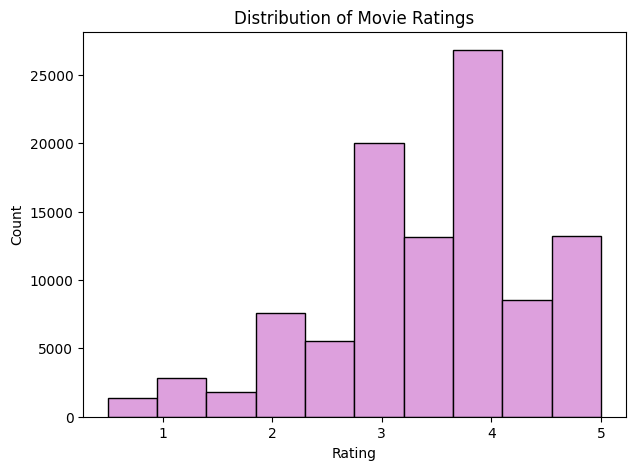

In [114]:
plt.figure(figsize=(7,5))
plt.hist(df['rating'], bins=10, edgecolor='black', color='plum')
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

**Overall, it shows that users are generally satisfied. The majority of ratings fall between 3.0 and 5.0, this suggests that the overall quality of movies in the dataset is perceived as good, or that users only bother to rate movies they enjoyed.**

#### 2. How has rating activity changed over time?

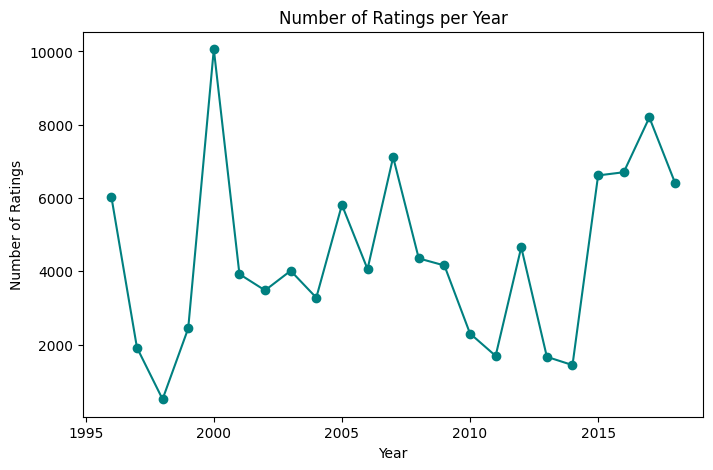

In [115]:
ratings_per_year = df.groupby('rating_year')['rating'].count().reset_index(name='num_ratings')

plt.figure(figsize=(8,5))
plt.plot(ratings_per_year['rating_year'], ratings_per_year['num_ratings'], marker='o', color='teal')
plt.title('Number of Ratings per Year')
plt.xlabel('Year')
plt.ylabel('Number of Ratings')
plt.show()


**The rating activity is highly unstable, especially because there was a massive surge that peaked dramatically around the year 2000, followed by a decline and inconsistent changes in subsequent years.**

#### 3. Which movies receive the highest ratings?

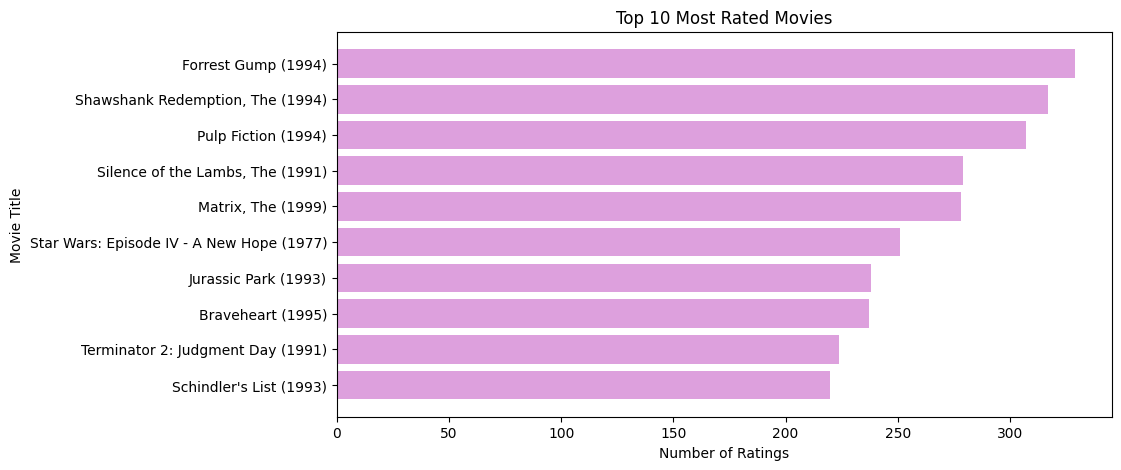

In [116]:
ratings_per_movie = df.groupby('title')['rating'].count().reset_index(name='num_ratings')
top_movies = ratings_per_movie.sort_values(by='num_ratings', ascending=False).head(10)

plt.figure(figsize=(10,5))
plt.barh(top_movies['title'], top_movies['num_ratings'], color='plum')
plt.title('Top 10 Most Rated Movies')
plt.xlabel('Number of Ratings')
plt.ylabel('Movie Title')
plt.gca().invert_yaxis()
plt.show()


**Movies with the most ratings are classics from 1990s. This means that having many ratings is more about a movie being popular and respected over time, rather than being a recent release. Because of this, these popular movies might affect recommendations that rely on ratings.**

#### 4. Do users differ in how generously they rate movies?

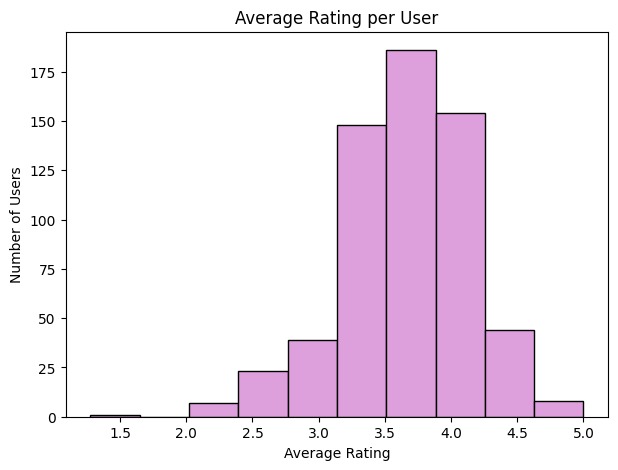

In [117]:
avg_rating_per_user = df.groupby('userId')['rating'].mean().reset_index(name='avg_user_rating')

plt.figure(figsize=(7,5))
plt.hist(avg_rating_per_user['avg_user_rating'], bins=10, color='plum', edgecolor='black')
plt.title('Average Rating per User')
plt.xlabel('Average Rating')
plt.ylabel('Number of Users')
plt.show()


**The finding confirms that users do not differ significantly in their generosity because most users rate movies similarly and tend to give high scores. Very few users give low ratings, so there aren’t many strict raters. This means that when building a recommendation system, we can’t just use the raw ratings, we need to adjust for the fact that users are generally generous.**

#### 5. Are movies with multiple genres rated differently than single-genre films?

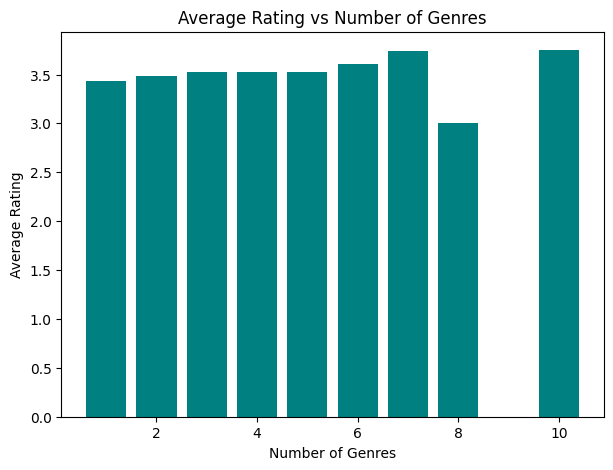

In [118]:
# Average rating by number of genres
genre_rating = df.groupby('num_genres')['rating'].mean().reset_index()

plt.figure(figsize=(7,5))
plt.bar(genre_rating['num_genres'], genre_rating['rating'], color='teal')
plt.title('Average Rating vs Number of Genres')
plt.xlabel('Number of Genres')
plt.ylabel('Average Rating')
plt.show()


**For most movies (1 to 7 genres), having more or fewer genres doesn’t really change the average rating.**

#### 6. Which decades produced the most-rated or highest-rated movies?

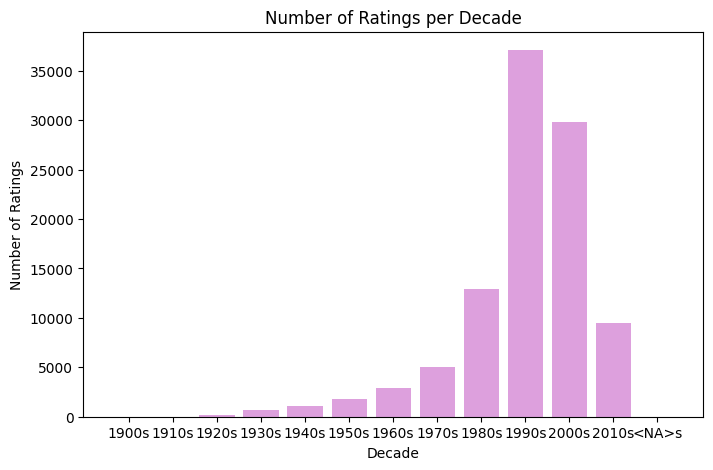

In [119]:
ratings_by_decade = df.groupby('decade')['rating'].count().reset_index(name='num_ratings')

plt.figure(figsize=(8,5))
plt.bar(ratings_by_decade['decade'].astype(str), ratings_by_decade['num_ratings'], color='plum')
plt.title('Number of Ratings per Decade')
plt.xlabel('Decade')
plt.ylabel('Number of Ratings')
plt.show()


**The vast majority of rating activity focuses on films released in the 1990s and 2000s. The recommendation system should therefore prioritize content and preferences related to these films.**

### CONCLUSION

The analysis showed clear patterns in movie ratings and user behavior. Most users rate movies positively, so this bias should be considered in modeling. Also, ratings are concentrated on movies from the 1990s and 2000s, a few popular classics get most of the ratings showing that popularity drives volume more than recency. Finally, the number of genres a movie has doesn’t strongly affect its average rating.